In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import skimage.feature as skf
from skimage import segmentation, color
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
def graph_based_segmentation(image):
    segments = segmentation.slic(image, compactness=30, n_segments=400)
    segmented_image = color.label2rgb(segments, image, kind='avg')
    return segmented_image, segments

In [ ]:
def extract_crack_features(image, segments):
    features = []
    for segment_label in np.unique(segments):
        mask = segments == segment_label
        segment_image = image * mask[:, :, np.newaxis]
        gray_segment = cv2.cvtColor(segment_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        
    
        glcm = skf.graycomatrix(gray_segment, distances=[1], angles=[0], symmetric=True, normed=True)
        contrast = skf.graycoprops(glcm, 'contrast')
        dissimilarity = skf.graycoprops(glcm, 'dissimilarity')
        homogeneity = skf.graycoprops(glcm, 'homogeneity')
        energy = skf.graycoprops(glcm, 'energy')
        correlation = skf.graycoprops(glcm, 'correlation')
        
    
        edges = cv2.Canny(gray_segment, threshold1=50, threshold2=150) 
        edge_count = np.sum(edges > 0)  
        
        
        edge_density = edge_count / (gray_segment.shape[0] * gray_segment.shape[1])
        
        
        features.append([
            contrast[0, 0], dissimilarity[0, 0], homogeneity[0, 0], energy[0, 0], correlation[0, 0],
            edge_count,edge_density
        ])
    
    return np.array(features)

In [ ]:
from tqdm import tqdm  

def create_dataset(image_folder, max_images_per_category=5000):
    X = []
    y = []
    
    
    for label, folder_name in enumerate(['Positive', 'Negative']):
        folder_path = os.path.join(image_folder, folder_name)
        image_files = os.listdir(folder_path)
        
        
        image_count = 0
        
        
        for image_name in tqdm(image_files, desc=f"Processing {folder_name}", unit="image"):
            
            if image_count >= max_images_per_category:
                print(f"Reached the limit of {max_images_per_category} images for {folder_name}. Moving to the next category.")
                break
            
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)

            
            
            segmented_image, segments = graph_based_segmentation(image)

            features = extract_crack_features(segmented_image, segments)
            
            
            if len(features) > 0:
                avg_features = np.mean(features, axis=0)
                X.append(avg_features)
                y.append(label)
                image_count += 1 
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [ ]:
def save_dataset_as_csv(X, y, output_file):
    
    feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation','edge count','edge density']
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")

In [ ]:
image_folder = r"C:\Users\EDWIN\OneDrive\Desktop\Study materials\SEM-6\MV Project\Dataset"
    

X, y = create_dataset(image_folder)
    

save_dataset_as_csv(X, y, 'extracted_features.csv')

Processing Positive:   0%|          | 0/20000 [00:00<?, ?image/s]

Processing Positive:  25%|██▌       | 5000/20000 [2:04:36<6:13:50,  1.50s/image]


Reached the limit of 5000 images for Positive. Moving to the next category.


Processing Negative:  25%|██▌       | 5000/20000 [1:59:33<5:58:39,  1.43s/image] 

Reached the limit of 5000 images for Negative. Moving to the next category.
Dataset saved to extracted_features.csv


In [4]:
df=pd.read_csv("extracted_features.csv")
df.head()

,contrast,dissimilarity,homogeneity,energy,correlation,edge count,edge density,label
0,7.267054,0.054844,0.999579,0.997519,0.906921,38.009091,0.000738,0
1,9.905927,0.065028,0.999570,0.997509,0.905286,38.111617,0.000740,0
2,7.555580,0.056139,0.999576,0.997518,0.906323,38.111364,0.000740,0
3,8.547949,0.059535,0.999579,0.997524,0.906009,37.950113,0.000736,0
4,9.876657,0.064061,0.999581,0.997525,0.907427,37.875283,0.000735,0


In [5]:
df.tail()

,contrast,dissimilarity,homogeneity,energy,correlation,edge count,edge density,label
9995,9.431047,0.063253,0.999575,0.997522,0.906068,37.773243,0.000733,1
9996,17.669901,0.084616,0.999595,0.997532,0.910585,37.637188,0.000730,1
9997,17.097890,0.084619,0.999581,0.997510,0.907863,38.034247,0.000738,1
9998,12.310385,0.071048,0.999589,0.997529,0.909407,37.641723,0.000730,1
9999,16.157144,0.082987,0.999573,0.997516,0.905747,37.959091,0.000737,1


In [14]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
    

model = build_model((X_train.shape[1],), y_train.shape[1])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50


C:\Users\EDWIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8018 - loss: 0.4441 - val_accuracy: 0.9335 - val_loss: 0.1753
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9216 - loss: 0.2184 - val_accuracy: 0.9445 - val_loss: 0.1541
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9316 - loss: 0.1806 - val_accuracy: 0.9470 - val_loss: 0.1477
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9297 - loss: 0.1968 - val_accuracy: 0.9470 - val_loss: 0.1443
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9289 - loss: 0.1712 - val_accuracy: 0.9490 - val_loss: 0.1392
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9381 - loss: 0.1667 - val_accuracy: 0.9445 - val_loss: 0.1412
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9379 - loss: 0.1655 - val_accuracy: 0.9470 - val_loss: 0.1337
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9390 - loss: 0.1541 - val_accuracy: 0.9470 - val_

In [16]:
model.save('trained_model.h5')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1012
           1       0.97      0.99      0.98       988

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Accuracy: 0.9805


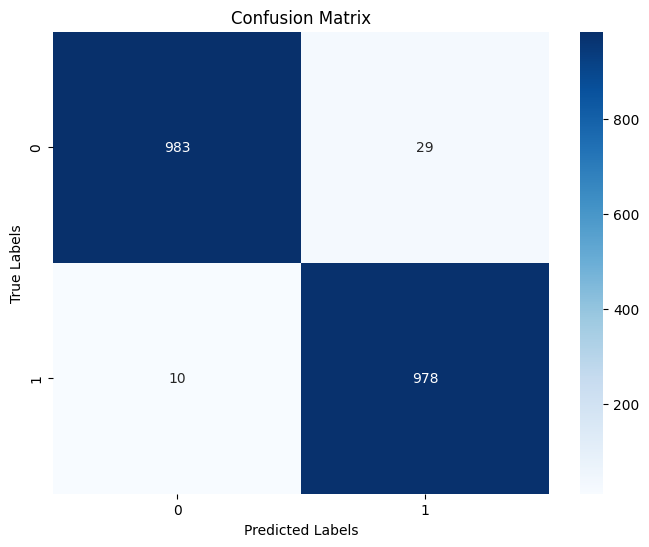

In [7]:
import pandas as pd 
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.utils import to_categorical

df=pd.read_csv('extracted_features.csv')

X=df.drop(columns=['label'])
y=df['label']

FEATURE_MODEL_PATH = "trained_model.h5"
model = load_model(FEATURE_MODEL_PATH)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (assuming a multi-class classification problem)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Ensure y_test is one-hot encoded, convert if necessary

# Print classification report
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
    